# Libraries

In [1]:
!pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.7 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting unins

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tqdm import tqdm
from IPython.display import Audio, display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, Conv2D, MaxPooling2D, Flatten, Reshape, TimeDistributed
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

# Preprocess

In [3]:
# Define emotions in TESS dataset
EMOTIONS = {
    'angry': 'angry',
    'disgust': 'disgust',
    'fear': 'fear',
    'happy': 'happy',
    'neutral': 'neutral',
    'ps': 'pleasant_surprise',
    'sad': 'sad'
}

In [4]:
# TESS dataset path
DATASET_PATH = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data" 

In [5]:
# Function to extract emotion from filename
def get_emotion(filename):
    for key in EMOTIONS:
        if key in filename.lower():
            return EMOTIONS[key]
    return "unknown"


In [6]:
# Load dataset
def load_data(dataset_path):
    data = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                emotion = get_emotion(file)
                data.append({"path": file_path, "emotion": emotion})
    return pd.DataFrame(data)

In [7]:
# Load the dataset
df = load_data(DATASET_PATH)

In [8]:
# Show dataset info
print(df.head())

                                                path emotion
0  /kaggle/input/toronto-emotional-speech-set-tes...    fear
1  /kaggle/input/toronto-emotional-speech-set-tes...    fear
2  /kaggle/input/toronto-emotional-speech-set-tes...    fear
3  /kaggle/input/toronto-emotional-speech-set-tes...    fear
4  /kaggle/input/toronto-emotional-speech-set-tes...    fear


In [9]:
# Function to play audio samples
def play_samples(df, num_samples=3):
    unique_emotions = df['emotion'].unique()
    for emotion in unique_emotions:
        emotion_df = df[df['emotion'] == emotion]
        sample = emotion_df.sample(n=num_samples, random_state=42)  # Pick one sample for each emotion
        for _, row in sample.iterrows():
            print(f"Emotion: {row['emotion']}")
            display(Audio(row["path"], autoplay=False))


In [10]:
# Play random audio samples
play_samples(df, num_samples=1)

Emotion: fear


Emotion: angry


Emotion: disgust


Emotion: neutral


Emotion: sad


Emotion: pleasant_surprise


Emotion: happy


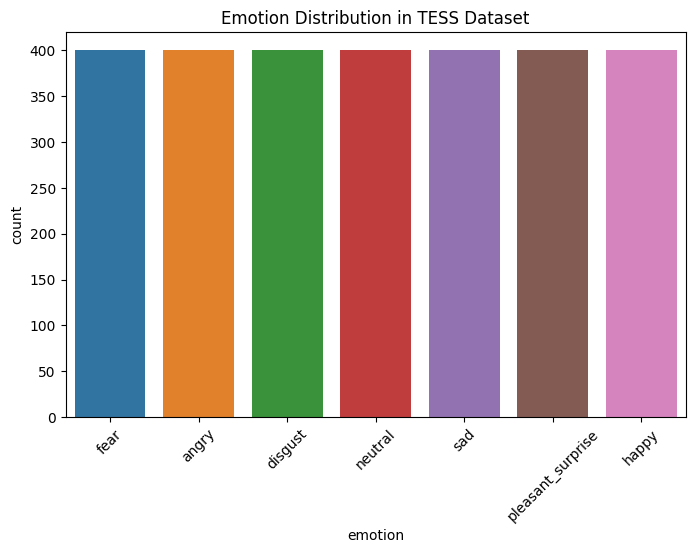

In [11]:
# Plot emotion distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="emotion", order=df["emotion"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Emotion Distribution in TESS Dataset")
plt.show()


In [12]:
# Feature extraction function
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # Extract features
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)

    return np.hstack([mfccs, chroma, contrast])

In [13]:
# Process all audio files
features, labels = [], []
for _, row in tqdm(df.iterrows(), total=len(df)):
    features.append(extract_features(row["path"]))
    labels.append(row["emotion"])

100%|██████████| 2800/2800 [02:03<00:00, 22.62it/s]


In [14]:
# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

In [15]:
# Show feature shape
print("Feature shape:", X.shape)
print("Labels shape:", y.shape)

Feature shape: (2800, 32)
Labels shape: (2800,)


# Training

In [16]:
use_split_size = 0.2
use_random_seed = 42
use_loss = "categorical_crossentropy"
use_epoch = 50
use_batch_size = 32

learning_rate = 0.0001  # Customize the learning rate here
adam_optimizer_lstm = Adam(learning_rate=learning_rate)
adam_optimizer_cnn = Adam(learning_rate=learning_rate)
adam_optimizer_hybrid = Adam(learning_rate=learning_rate)

# Define callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, mode="min")
tensorboard = TensorBoard(log_dir="logs", histogram_freq=1)

# List of callbacks
callbacks_list = [early_stopping, reduce_lr, tensorboard]

## LSTM

### Creating the Model

In [17]:
# Encode labels into numerical format
label_encoder_LSTM = LabelEncoder()
y_encoded_LSTM = label_encoder_LSTM.fit_transform(y)  # Convert labels to numbers
y_onehot_LSTM = to_categorical(y_encoded_LSTM)  # Convert to one-hot encoding

In [18]:
# Reshape X to fit LSTM (samples, time steps, features)
X_LSTM = np.expand_dims(X, axis=1)  # (num_samples, 1, num_features)

In [19]:
# Split data into training and testing sets
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(X_LSTM, y_onehot_LSTM, test_size=use_split_size, random_state=use_random_seed)

In [20]:
# Define LSTM model
model_LSTM = Sequential([
    Input(shape=(X_LSTM.shape[1], X_LSTM.shape[2])),  # Input layer

    LSTM(128, return_sequences=True),
    BatchNormalization(),  # Normalize activations
    Dropout(0.3),  # Reduce overfitting

    LSTM(64),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(y_onehot_LSTM.shape[1], activation="softmax")  # Output layer
])

In [21]:
# Compile the model
model_LSTM.compile(loss=use_loss, optimizer=adam_optimizer_lstm, metrics=["accuracy"])

In [22]:
# Train the model
history_LSTM = model_LSTM.fit(
    X_train_LSTM, y_train_LSTM, 
    epochs=use_epoch, 
    batch_size=use_batch_size, 
    validation_data=(X_test_LSTM, y_test_LSTM), 
    callbacks=callbacks_list
)

Epoch 1/50
70/70 [==============================] - 6s 26ms/step - loss: 2.5843 - accuracy: 0.1692 - val_loss: 1.9759 - val_accuracy: 0.1482 - lr: 1.0000e-04
Epoch 2/50
70/70 [==============================] - 1s 11ms/step - loss: 2.1774 - accuracy: 0.2402 - val_loss: 1.9949 - val_accuracy: 0.1482 - lr: 1.0000e-04
Epoch 3/50
70/70 [==============================] - 1s 11ms/step - loss: 1.9067 - accuracy: 0.3116 - val_loss: 1.9356 - val_accuracy: 0.1500 - lr: 1.0000e-04
Epoch 4/50
70/70 [==============================] - 1s 11ms/step - loss: 1.7616 - accuracy: 0.3513 - val_loss: 1.7909 - val_accuracy: 0.2179 - lr: 1.0000e-04
Epoch 5/50
70/70 [==============================] - 1s 10ms/step - loss: 1.5921 - accuracy: 0.4085 - val_loss: 1.5921 - val_accuracy: 0.4411 - lr: 1.0000e-04
Epoch 6/50
70/70 [==============================] - 1s 11ms/step - loss: 1.5427 - accuracy: 0.4286 - val_loss: 1.3703 - val_accuracy: 0.5696 - lr: 1.0000e-04
Epoch 7/50
70/70 [==============================] - 

### Evaluating the Model

In [23]:
test_loss_LSTM, test_acc_LSTM = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM)
print(f"Test Accuracy: {test_acc_LSTM:.4f}")

18/18 [==============================] - 0s 3ms/step - loss: 0.1477 - accuracy: 0.9750
Test Accuracy: 0.9750


In [24]:
# Plot training loss & accuracy
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Loss Curve')

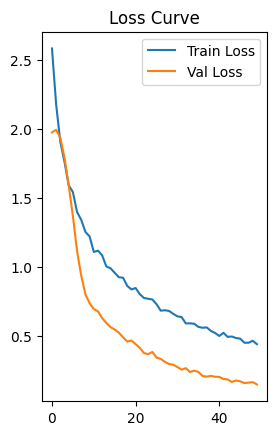

In [25]:
# Loss
plt.subplot(1, 2, 1)
plt.plot(history_LSTM.history["loss"], label="Train Loss")
plt.plot(history_LSTM.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")

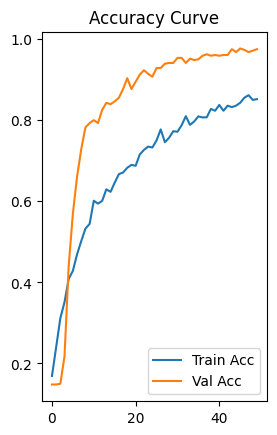

In [26]:
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_LSTM.history["accuracy"], label="Train Acc")
plt.plot(history_LSTM.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

In [27]:
# Generate classification report
y_pred_LSTM = np.argmax(model_LSTM.predict(X_test_LSTM), axis=1)
y_true_LSTM = np.argmax(y_test_LSTM, axis=1)

18/18 [==============================] - 1s 3ms/step


In [28]:
print(classification_report(y_true_LSTM, y_pred_LSTM, target_names=label_encoder_LSTM.classes_))

                   precision    recall  f1-score   support

            angry       0.97      0.99      0.98        86
          disgust       0.99      0.96      0.97        74
             fear       0.99      0.99      0.99        89
            happy       1.00      0.94      0.97        83
          neutral       0.97      0.99      0.98        69
pleasant_surprise       0.92      0.97      0.94        70
              sad       0.99      0.99      0.99        89

         accuracy                           0.97       560
        macro avg       0.97      0.97      0.97       560
     weighted avg       0.98      0.97      0.98       560



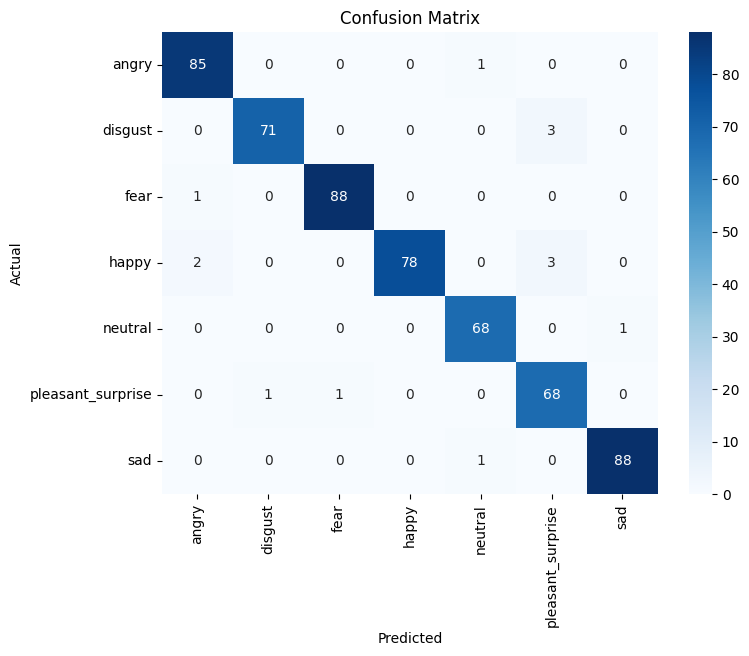

In [29]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true_LSTM, y_pred_LSTM), annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder_LSTM.classes_, yticklabels=label_encoder_LSTM.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [30]:
# Save the model
model_LSTM.save("lstm_emotion_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## CNN

In [31]:
# Encode labels into numerical format
label_encoder_CNN = LabelEncoder()
y_encoded_CNN = label_encoder_CNN.fit_transform(y)  # Convert labels to numbers
y_onehot_CNN = to_categorical(y_encoded_CNN)  # Convert to one-hot encoding

In [32]:
# Reshape X to fit CNN (samples, height, width, channels)
X_CNN = np.expand_dims(X, axis=-1)  # Assuming X_CNN is (num_samples, height, width)

In [33]:
# Split data into training and testing sets
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(X_CNN, y_onehot_CNN, test_size=use_split_size, random_state=use_random_seed)

In [34]:
# Define CNN model
model_CNN = Sequential([
    Input(shape=(X_CNN.shape[1], X_CNN.shape[2], 1)),
    
    Conv2D(32, (3, 1), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.3),

    Conv2D(64, (3, 1), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.3),

    Conv2D(128, (3, 1), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(y_onehot_CNN.shape[1], activation="softmax")  # Output layer
])


In [35]:
# Compile the model
model_CNN.compile(loss=use_loss, optimizer=adam_optimizer_cnn, metrics=["accuracy"])

In [36]:
# Train the model
history_CNN = model_CNN.fit(
    X_train_CNN, y_train_CNN, 
    epochs=use_epoch, 
    batch_size=use_batch_size, 
    validation_data=(X_test_CNN, y_test_CNN),
    callbacks=callbacks_list 
)

Epoch 1/50
70/70 [==============================] - 3s 16ms/step - loss: 2.7425 - accuracy: 0.1429 - val_loss: 1.8816 - val_accuracy: 0.2589 - lr: 1.0000e-04
Epoch 2/50
70/70 [==============================] - 1s 12ms/step - loss: 2.5005 - accuracy: 0.1839 - val_loss: 1.8352 - val_accuracy: 0.3393 - lr: 1.0000e-04
Epoch 3/50
70/70 [==============================] - 1s 12ms/step - loss: 2.3352 - accuracy: 0.2179 - val_loss: 1.7534 - val_accuracy: 0.3589 - lr: 1.0000e-04
Epoch 4/50
70/70 [==============================] - 1s 12ms/step - loss: 2.1464 - accuracy: 0.2527 - val_loss: 1.6072 - val_accuracy: 0.3804 - lr: 1.0000e-04
Epoch 5/50
70/70 [==============================] - 1s 11ms/step - loss: 2.0317 - accuracy: 0.2812 - val_loss: 1.4304 - val_accuracy: 0.4357 - lr: 1.0000e-04
Epoch 6/50
70/70 [==============================] - 1s 11ms/step - loss: 1.8803 - accuracy: 0.3246 - val_loss: 1.3360 - val_accuracy: 0.4982 - lr: 1.0000e-04
Epoch 7/50
70/70 [==============================] - 

In [37]:
# Evaluate the model
test_loss_CNN, test_acc_CNN = model_CNN.evaluate(X_test_CNN, y_test_CNN)
print(f"Test Accuracy: {test_acc_CNN:.4f}")

18/18 [==============================] - 0s 4ms/step - loss: 0.3718 - accuracy: 0.8839
Test Accuracy: 0.8839


In [38]:
# Plot training loss & accuracy
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Loss Curve')

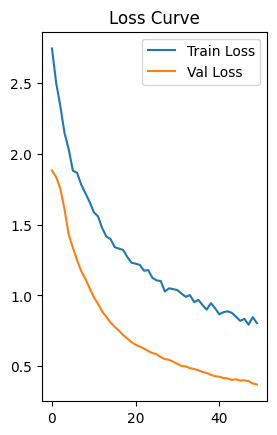

In [39]:
# Loss
plt.subplot(1, 2, 1)
plt.plot(history_CNN.history["loss"], label="Train Loss")
plt.plot(history_CNN.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")

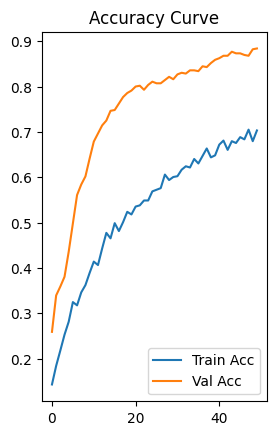

In [40]:
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_CNN.history["accuracy"], label="Train Acc")
plt.plot(history_CNN.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

In [41]:
# Generate classification report
y_pred_CNN = np.argmax(model_CNN.predict(X_test_CNN), axis=1)
y_true_CNN = np.argmax(y_test_CNN, axis=1)

18/18 [==============================] - 0s 4ms/step


In [42]:
print(classification_report(y_true_CNN, y_pred_CNN, target_names=label_encoder_CNN.classes_))

                   precision    recall  f1-score   support

            angry       0.95      0.93      0.94        86
          disgust       0.77      1.00      0.87        74
             fear       0.88      0.97      0.92        89
            happy       0.98      0.75      0.85        83
          neutral       0.98      0.72      0.83        69
pleasant_surprise       0.76      0.79      0.77        70
              sad       0.92      0.99      0.95        89

         accuracy                           0.88       560
        macro avg       0.89      0.88      0.88       560
     weighted avg       0.90      0.88      0.88       560



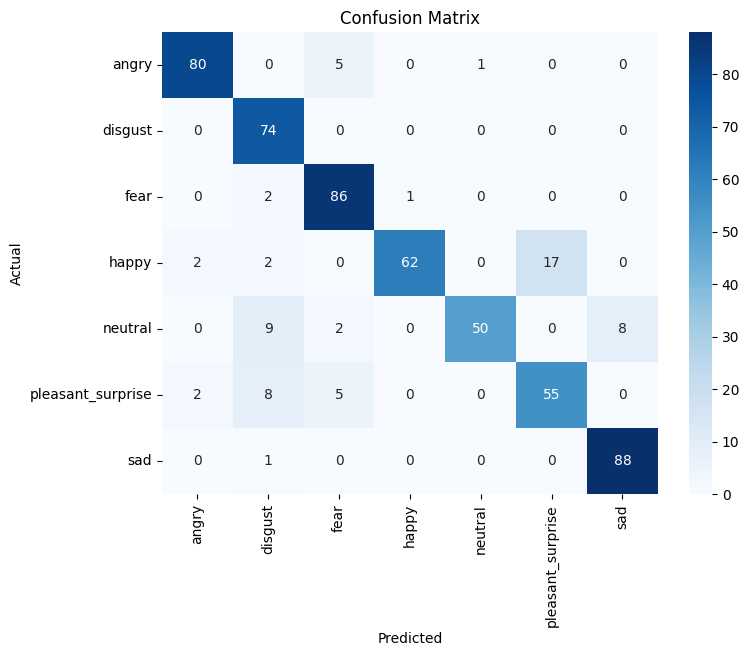

In [43]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true_CNN, y_pred_CNN), annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder_CNN.classes_, yticklabels=label_encoder_CNN.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [44]:
# Save the model
model_CNN.save("cnn_emotion_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Hybrid (LSTM + CNN)

In [45]:
# Encode labels into numerical format
label_encoder_CNN_LSTM = LabelEncoder()
y_encoded_CNN_LSTM = label_encoder_CNN_LSTM.fit_transform(y)  # Convert labels to numbers
y_onehot_CNN_LSTM = to_categorical(y_encoded_CNN_LSTM)  # Convert to one-hot encoding

In [46]:
# Reshape X to fit CNN input shape
X_CNN_LSTM = np.expand_dims(X, axis=-1)

In [47]:
# Split data into training and testing sets
X_train_CNN_LSTM, X_test_CNN_LSTM, y_train_CNN_LSTM, y_test_CNN_LSTM = train_test_split(X_CNN_LSTM, y_onehot_CNN_LSTM, test_size=use_split_size, random_state=use_random_seed)

In [48]:
# Define CNN + LSTM hybrid model
model_CNN_LSTM = Sequential([
    Input(shape=(X_CNN_LSTM.shape[1], X_CNN_LSTM.shape[2], 1)),  
    
    Conv2D(32, (3, 1), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.3),

    Conv2D(64, (3, 1), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.3),

    Conv2D(128, (3, 1), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.3),

    TimeDistributed(Flatten()),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(y_onehot_CNN_LSTM.shape[1], activation="softmax")  # Output layer
])


In [49]:
# Compile the model
model_CNN_LSTM.compile(loss=use_loss, optimizer=adam_optimizer_hybrid, metrics=["accuracy"])

In [50]:
# Train the model
history_CNN_LSTM = model_CNN_LSTM.fit(
    X_train_CNN_LSTM, y_train_CNN_LSTM, 
    epochs=use_epoch, 
    batch_size=use_batch_size, 
    validation_data=(X_test_CNN_LSTM, y_test_CNN_LSTM),
    callbacks=callbacks_list
)

Epoch 1/50
70/70 [==============================] - 10s 33ms/step - loss: 2.2754 - accuracy: 0.1518 - val_loss: 1.9406 - val_accuracy: 0.1839 - lr: 1.0000e-04
Epoch 2/50
70/70 [==============================] - 1s 17ms/step - loss: 2.1724 - accuracy: 0.1527 - val_loss: 1.9347 - val_accuracy: 0.1893 - lr: 1.0000e-04
Epoch 3/50
70/70 [==============================] - 1s 16ms/step - loss: 2.0476 - accuracy: 0.1772 - val_loss: 1.9234 - val_accuracy: 0.2196 - lr: 1.0000e-04
Epoch 4/50
70/70 [==============================] - 1s 16ms/step - loss: 2.0176 - accuracy: 0.1937 - val_loss: 1.9025 - val_accuracy: 0.2786 - lr: 1.0000e-04
Epoch 5/50
70/70 [==============================] - 1s 16ms/step - loss: 1.9466 - accuracy: 0.2281 - val_loss: 1.8705 - val_accuracy: 0.3536 - lr: 1.0000e-04
Epoch 6/50
70/70 [==============================] - 1s 16ms/step - loss: 1.9199 - accuracy: 0.2250 - val_loss: 1.8189 - val_accuracy: 0.3875 - lr: 1.0000e-04
Epoch 7/50
70/70 [==============================] -

In [51]:
# Evaluate the model
test_loss_CNN_LSTM, test_acc_CNN_LSTM = model_CNN_LSTM.evaluate(X_test_CNN_LSTM, y_test_CNN_LSTM)
print(f"Test Accuracy: {test_acc_CNN_LSTM:.4f}")

18/18 [==============================] - 0s 5ms/step - loss: 0.3489 - accuracy: 0.9089
Test Accuracy: 0.9089


In [52]:
# Plot training loss & accuracy
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Loss Curve')

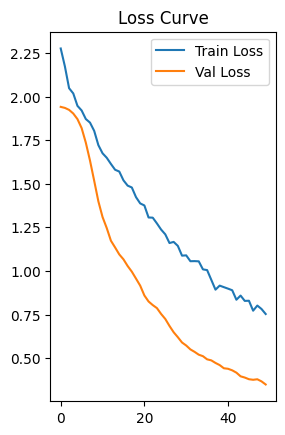

In [53]:
# Loss
plt.subplot(1, 2, 1)
plt.plot(history_CNN_LSTM.history["loss"], label="Train Loss")
plt.plot(history_CNN_LSTM.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")

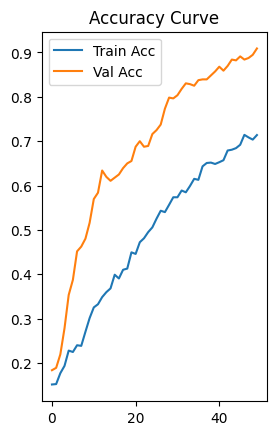

In [54]:
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_CNN_LSTM.history["accuracy"], label="Train Acc")
plt.plot(history_CNN_LSTM.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

In [55]:
# Generate classification report
y_pred_CNN_LSTM = np.argmax(model_CNN_LSTM.predict(X_test_CNN_LSTM), axis=1)
y_true_CNN_LSTM = np.argmax(y_test_CNN_LSTM, axis=1)

18/18 [==============================] - 1s 5ms/step


In [56]:
print(classification_report(y_true_CNN_LSTM, y_pred_CNN_LSTM, target_names=label_encoder_CNN_LSTM.classes_))

                   precision    recall  f1-score   support

            angry       0.93      0.87      0.90        86
          disgust       0.88      0.97      0.92        74
             fear       0.89      0.97      0.92        89
            happy       0.92      0.95      0.93        83
          neutral       0.95      0.81      0.87        69
pleasant_surprise       0.85      0.79      0.81        70
              sad       0.96      0.97      0.96        89

         accuracy                           0.91       560
        macro avg       0.91      0.90      0.90       560
     weighted avg       0.91      0.91      0.91       560



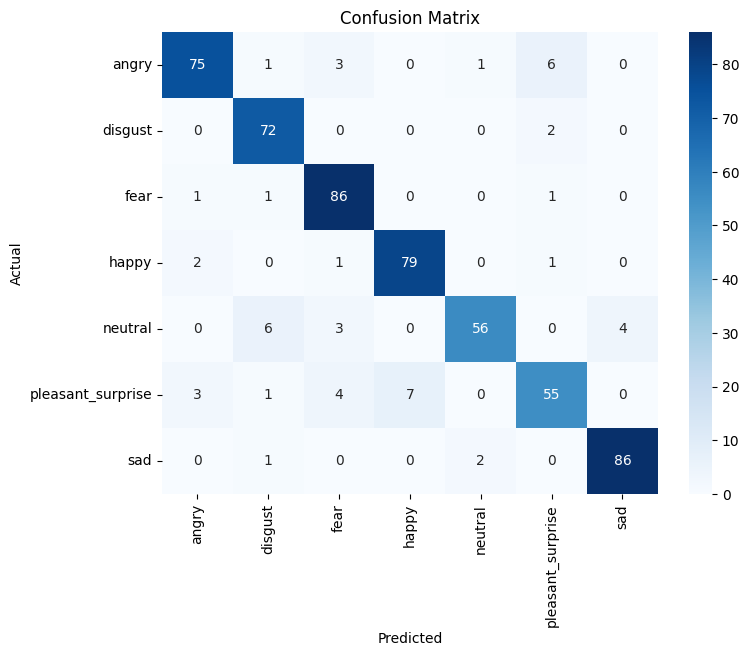

In [57]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true_CNN_LSTM, y_pred_CNN_LSTM), annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder_CNN_LSTM.classes_, yticklabels=label_encoder_CNN_LSTM.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [58]:
# Save the model
model_CNN_LSTM.save("cnn_lstm_emotion_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
